# **Project work: A mini segmentation challenge**

<div style="color:#777777;margin-top: -15px;">
<b>Course</b>: MSLS / CO4 |
<b>Version</b>: v1.2 <br><br>
<!-- Date: 10.04.2025 -->
<!-- Comments: Fully refactored. -->
</div>


**Student**: $\Rightarrow$  Mohan Adluru & Shweta Dayal  
**Email**: $\Rightarrow$ adlurmoh@students.zhaw.ch & dayalshw@students.zhaw.ch  
**University**: $\Rightarrow$  ZHAW  
**Semester**: $\Rightarrow$  SS25  
**Date**: $\Rightarrow$  31.05.2025


<br>

## **Abstract**

*$\Rightarrow$ A brief summary of your project in 2-3 sentences.*



<br><br>

----

## **Table of contents**
<!-- Unfortunately, the following does not always work correctly -->
* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)  
* [6. Discussion](#sec_discussion)  
* [Appendix: Hints](#sec_hints)  


---

## **Prerequisites / Setup**

$\Rightarrow$ Special setup instructions, imports and configurations go here.


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io, morphology, filters, segmentation
from skimage.morphology import remove_small_objects, binary_closing, binary_erosion, disk
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes, distance_transform_edt, label
from skimage.color import label2rgb
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_erosion, disk
from skimage.color import gray2rgb
from skimage.io import imsave

# Helper to show image
def show_image(img, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(img, path, name):

    # Define output path
    output_dir = path
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, f"{name}.png")

    # Save the final binary mask (uint8 format)
    imsave(output_path, img.astype(np.uint8))
    print(f"Saved final feathered image to: {output_path}")



---


<a id='sec_dataset'></a>

## **Dataset**

*$\Rightarrow$ Describe your dataset.*

### **Requirements**
* Provide a dataset with at least 10 image samples.
* The dataset must be no larger than 200 MB. If it exceeds this size, please contact the tutor in advance.
* Ensure that you have the rights to use and share the data (check the usage license).
* The images should clearly show a recognizable structure of interest.
* Avoid datasets with too much variation.
* Each student/team must use a different dataset!



---

<a id='sec_preprocessing'></a>

## **Preprocessing**

*$\Rightarrow$ Describe the pre-processing steps applied to enhance the input images.*

*Note: The specific steps will depend on your dataset and the intended application.*

### **Instructions:**
* Improve image quality by reducing noise, adjusting contrast, or normalizing intensity.
* Standardize image dimensions and formats for consistent input to analysis pipelines.
* Highlight or isolate relevant structures to support downstream processing.




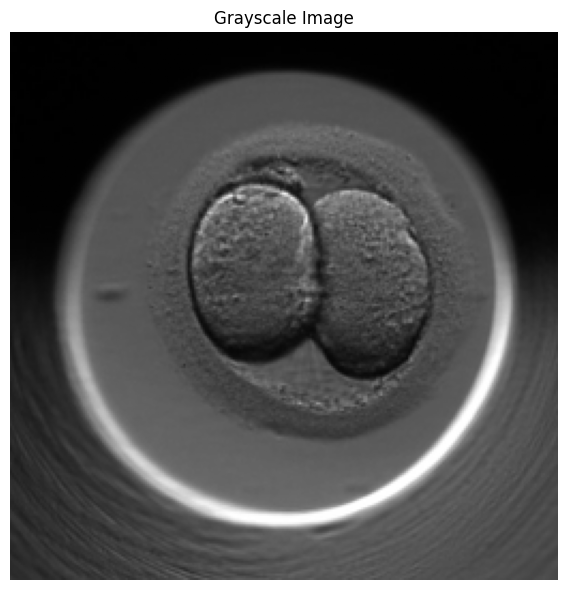

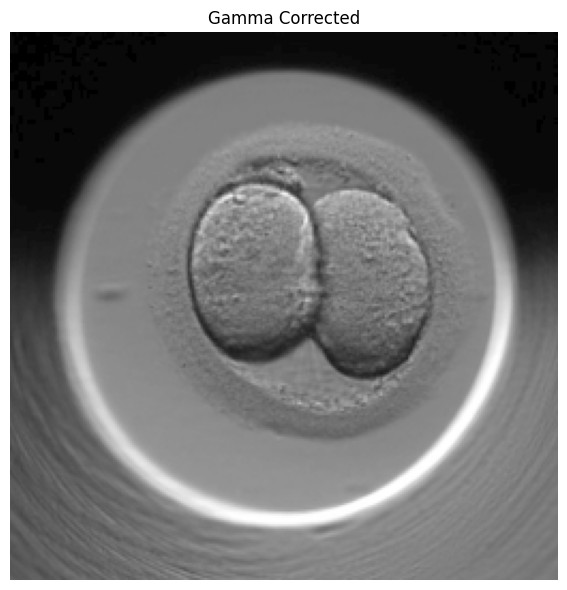

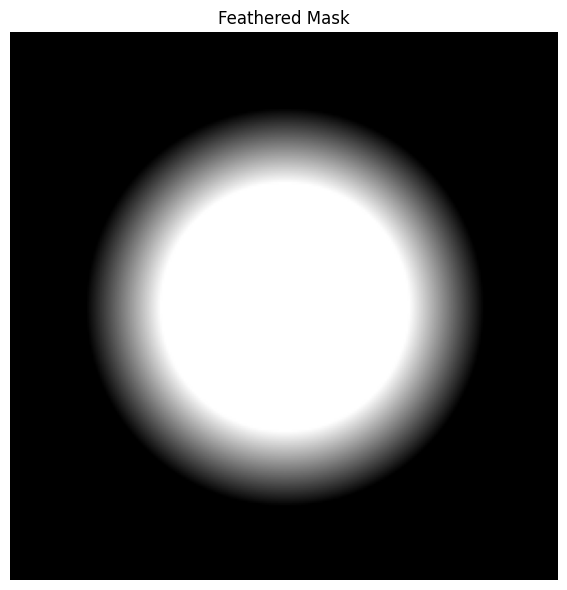

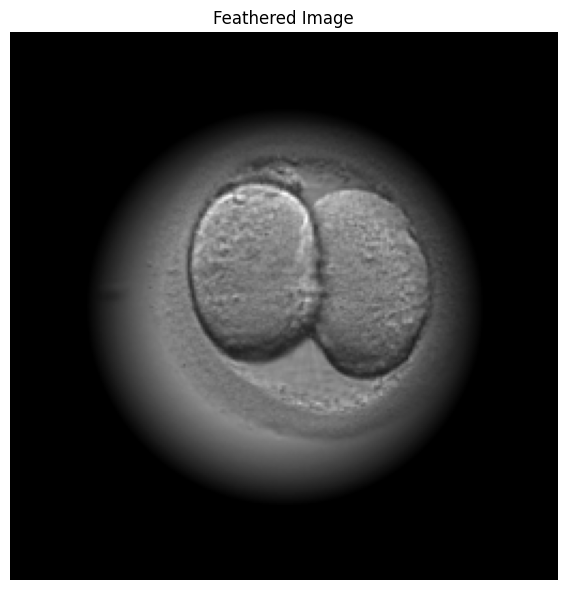

In [3]:
# === Step 1: Load and Convert to Grayscale ===
image_path = 'Data/2Cell/008.png'
image = io.imread(image_path)
if image.ndim == 3:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
else:
    gray = image
show_image(gray, "Grayscale Image")

# === Step 2: Gamma Correction ===
GAMMA = 0.6  # hyperparameter: adjust contrast (0.5 - 0.8)
gray = np.power(gray / 255.0, GAMMA)
gray = (gray * 255).astype(np.uint8)
show_image(gray, "Gamma Corrected")

# === Step 3: Feathered Circular Mask ===
h, w = gray.shape
center_y, center_x = h // 2, w // 2
radius = min(center_y, center_x) - 70  # hyperparameter: mask radius
feather_width = 35  # hyperparameter: feather edge thickness
Y, X = np.ogrid[:h, :w]
distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
mask = np.zeros_like(gray, dtype=np.float32)
mask[distance_from_center <= radius] = 1
feather_zone = (distance_from_center > radius) & (distance_from_center <= radius + feather_width)
mask[feather_zone] = 1.0 - ((distance_from_center[feather_zone] - radius) / feather_width)
feathered = (gray * mask).astype(np.uint8)
show_image(mask, "Feathered Mask")
show_image(feathered, "Feathered Image")

In [16]:
path = 'Data/2Cell_feather'
save_image(feathered,path,'008_feathered')

Saved final feathered image to: Data/2Cell_feather\008_feathered.png


---

<a id='sec_manual_segmentation'></a>

## **Manual segmentation**

*$\Rightarrow$ Describe the manual segmentation step*


### **Instructions:**
* Use a suitable tool to manually segment the structures of interest.  
* These segmentations will be needed for further analysis (or model training).  
* If your dataset already includes segmentation masks, you still need to demonstrate how such masks can be created manually.

## Here

---

<a id='sec_automated_segmentation'></a>

## **Automated Segmentation**

*$\Rightarrow$ Describe how the images are segmented using Python.*

### **Instructions:**
* Perform the segmentation in Python.
* You may use external libraries or tools (e.g., OpenCV, scikit-image).
* Implement a function `segment(image, ...)` that takes an image as input and returns a segmentation mask for the structure of interest.


In [ ]:
def segment(image, 
            sobel_thresh=31, 
            fg_thresh=0.2, 
            min_size=150, 
            erosion_radius=3, 
            marker_fraction=0.85, #0.9,0.95,0.98
            final_erode_radius=2):
    """
    Perform 2-cell embryo segmentation.

    Args:
        image: Grayscale image (numpy array)
        sobel_thresh: Threshold for sobel edge mask
        fg_thresh: Foreground distance threshold fraction
        min_size: Min object size to keep
        erosion_radius: Radius for erosion before splitting
        marker_fraction: Marker distance threshold fraction
        final_erode_radius: Final erosion per embryo

    Returns:
        combined_binary (final split binary mask), overlay (RGB visualization)
    """
    # === Step 1: Edge Detection with Sobel ===
    sobel = filters.sobel(image)
    sobel = (sobel / sobel.max() * 255).astype(np.uint8)

    # === Step 2: Binary mask ===
    binary_mask = sobel > sobel_thresh

    # === Step 3: Distance Transform ===
    distance = distance_transform_edt(binary_mask)

    # === Step 4: Sure Foreground ===
    sure_fg = distance > fg_thresh * distance.max()
    sure_bg = morphology.binary_dilation(binary_mask, disk(5))
    unknown = sure_bg ^ sure_fg

    # === Step 5: Watershed ===
    markers, _ = label(sure_fg)
    markers[unknown] = 0
    labels = segmentation.watershed(-distance, markers, mask=binary_mask)

    # === Step 6: Clean mask ===
    sure_fg_img = sure_fg.astype(np.uint8)
    clean_fg = remove_small_objects(sure_fg_img > 0, min_size=min_size)
    clean_fg = binary_closing(clean_fg, disk(3))
    clean_fg = binary_fill_holes(clean_fg)

    # === Step 7: Refine splitting ===
    eroded = binary_erosion(clean_fg, disk(erosion_radius))
    distance_refined = distance_transform_edt(eroded)
    markers_refined, _ = label(distance_refined > marker_fraction * distance_refined.max())
    labels_refined = segmentation.watershed(-distance_refined, markers_refined, mask=clean_fg)

    # === Step 8: Remove shared boundary ===
    boundary = find_boundaries(labels_refined, mode='inner')
    labels_refined[boundary] = 0

    # === Step 9: Extract embryos ===
    embryo1 = (labels_refined == 1)
    embryo2 = (labels_refined == 2)

    eroded1 = binary_erosion(embryo1, disk(final_erode_radius))
    eroded2 = binary_erosion(embryo2, disk(final_erode_radius))

    embryo1_mask = (eroded1.astype(np.uint8)) * 255
    embryo2_mask = (eroded2.astype(np.uint8)) * 255

    combined_binary = np.zeros_like(image, dtype=np.uint8)
    combined_binary[eroded1] = 255
    combined_binary[eroded2] = 255

    overlay = gray2rgb(image.copy())
    overlay[eroded1] = [255, 0, 0]
    overlay[eroded2] = [0, 0, 255]

    return combined_binary, overlay

In [9]:
gray_image = io.imread("Data/2Cell_feather/008_feather.png", as_gray=True)
binary_mask, overlay_image = segment(gray_image)

In [17]:
path = '2Cell_segmented'
save_image(binary_mask,path,'008_segmented')

Saved final feathered image to: 2Cell_segmented\008_segmented.png


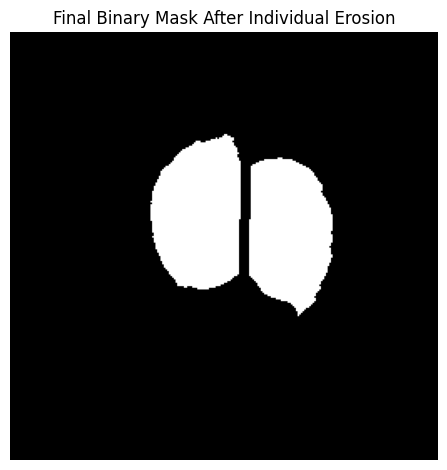

In [11]:
plt.imshow(binary_mask, cmap='gray')
plt.title("Final Binary Mask After Individual Erosion")
plt.axis('off')
plt.tight_layout()
plt.show()

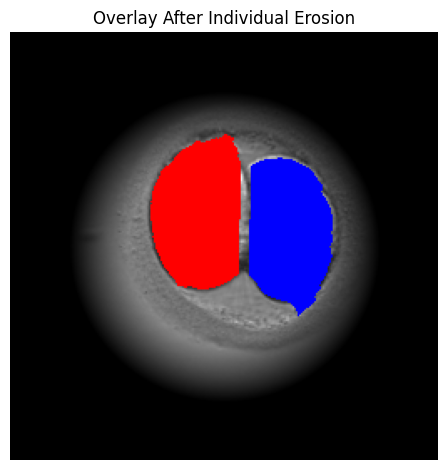

In [12]:
plt.imshow(overlay_image)
plt.title("Overlay After Individual Erosion")
plt.axis("off")
plt.tight_layout()
plt.show()

---

<a id='sec_evaluation'></a>

## **Evaluation**

*$\Rightarrow$ Describe the evaluation of your results.*

### **Instructions:**
* Select an evaluation method to compare two binary segmentation masks and quantify how well they match (e.g., using the Dice score).
* Hint: Implement a function `evaluate(mask1, mask2)` that returns the chosen evaluation score(s).
* Calculate the mean and standard deviation of the scores across the entire dataset.



In [13]:
def dice_coefficient(mask1, mask2):
    """
    Calculate Dice Similarity Coefficient between two binary masks.

    Parameters:
    - mask1, mask2: numpy arrays of the same shape, binary (0 or 255 or 0 and 1)

    Returns:
    - dice: float, Dice coefficient between the masks
    """
    # Convert to boolean
    mask1 = (mask1 > 0).astype(np.bool_)
    mask2 = (mask2 > 0).astype(np.bool_)

    intersection = np.logical_and(mask1, mask2).sum()
    total = mask1.sum() + mask2.sum()

    if total == 0:
        return 1.0 if np.array_equal(mask1, mask2) else 0.0

    dice = 2.0 * intersection / total
    return dice

In [20]:
# Run segmentation
image = io.imread("2Cell_segmented/008_segmented.png", as_gray=True)
predicted_mask, _ = segment(image)

# Load ground truth
ground_truth = io.imread("Masks/001.tif")

# Evaluate
dice = dice_coefficient(predicted_mask, ground_truth)
print(f"Dice Score: {dice:.4f}")

Dice Score: 0.9274


---

<a id='sec_discussion'></a>

## **Discussion**

*$\Rightarrow$ Briefly discuss your results and share your key observations and your experiences and leaernings.*



---

<a id='sec_references'></a>

## **References**

*$\Rightarrow$ List all relevant references (as URLs).*

*Also, clearly state whether you used generative AI tools (e.g., ChatGPT, GitHub Copilot) and describe how they were used.*



<br><br><br><br><br><br><br><br>

---

<a id='sec_hints'></a>

## **Appendix: Hints**

### **Markdown / HTML**

The following tutorials might be useful if you are not yet familiar with Markdown:

- [Quick overview](https://www.writethedocs.org/guide/writing/markdown/)
- [Markdown GitHub-style](https://docs.github.com/en/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax)
- [More detailed tutorial](https://www.datacamp.com/tutorial/markdown-in-jupyter-notebook)

By the way: In Markdown cells, you can also use simple HTML (e.g., `<key>...</key>` blocks) to gain more control over formatting.





### **Display images**

You may want to display your data, if possible. Here are a few ways to do that:

An easy method for displaying 2D images is using the [**Pillow**](https://pillow.readthedocs.io/en/stable/) library:

In [ ]:
# Option 1: Display an image with Pillow
path = "../data/images/kidney-cells-lowres.jpg"
image = PIL.Image.open(path)
display(image)                  

If you are working with the data as a NumPy array (e.g., when using the OpenCV interface), you can also display it using **matplotlib**.

In [ ]:
# Option 2: OpenCV / Matplotlib
path = "../data/images/ct-brain-slices.jpg"
image = cv.imread(path)
plt.imshow(image)
plt.axis("off");

For convenience, we also provide a `display_image()` function in the **tools** library, which includes various utilities used throughout this course.

In [ ]:
# Option 3: Directly display a file
path = "../data/images/kidney-cells.jpg"
tools.display_image(path, scale=0.5)

<br>
<br>


### **Display overlays**

When segmenting images, you may want to overlay the input image with the segmentation mask.  
There are several ways to do this – here are a few ideas:


In [ ]:
################################################
# Idea 1: Overlay a color on a grayscale image
################################################

# Enforce a (3-channel) color image
path_image = "../data/images/neurons-cultured.jpg"
image = cv.imread(path_image, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Mask image
path_mask = "../data/images/neurons-cultured-mask.png"
mask = cv.imread(path_mask, cv.IMREAD_GRAYSCALE)

# Create overlay (RGB)
overlay_color = [255, 0, 0]
overlay_alpha = 0.3
overlay = image.copy()
overlay[mask > 0] = overlay_color
overlay = cv.addWeighted(image, 1 - overlay_alpha, overlay, overlay_alpha, 0)

# Display the images next to each other using a convenience function
tools.show_image_chain((image, overlay), titles=("Input", "Overlay"))

In [ ]:
################################################
# Idea 2: Overlay contours on a grayscale image
################################################

overlay_color = [255, 255, 0]
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_contours = image.copy()
cv.drawContours(image_contours, contours, -1, overlay_color, line_width)
tools.show_image_chain((image, image_contours), titles=("Input", "Contours"))

An advanced example: We can colorize different contours using distinct colors.

#### ***Strategy:***
- Use connected component labeling to assign a unique integer label to each region.
- Map each label to a different color by encoding it in the hue channel (in the HSV color space).
- Extract contours from the mask (ensure the mask is binary).
- Draw the contours with their assigned colors onto the original image.


In [ ]:
################################################
# Idea 3: Use colorized contours
################################################

# This will contain the result
image_contours = image.copy()

# Compute the "connected components" (= separate objects in the mask)
n_labels, labels = cv.connectedComponents(mask)

# Assign a different color to each label in the hue channel (HSV color space)
hue = np.uint8(150*labels/np.max(labels))
blank = 255*np.ones_like(hue)
labels = cv.merge([hue, blank, blank])

# Convert from HSV color space to RGB
labels = cv.cvtColor(labels, cv.COLOR_HSV2RGB)
# Set the background label (labels==0) to black
labels[labels==0] = 0

# Create a mask of the contours
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
mask_contours = cv.drawContours(np.zeros_like(mask), contours, -1, 255, line_width)

# Assign the colored labels only along the contours
image_contours[mask_contours>0] = labels[mask_contours>0]

# Display the result
tools.show_image_chain((image, image_contours), titles=("Input", "Labeled contours"))

<br>
<br>



### **How to convert a Jupyter notebook into a HTML/PDF:**

- Don't forget to **save your notebook** before converting!
- Install the conversion tool (if not already installed): `pip install nbconvert`
- Convert the notebook to an HTML file: `jupyter nbconvert --to html main.ipynb`  
  The HTML file will be saved in the same folder as your notebook.
- Open the HTML file in a browser and print (or save) it as a PDF.
- Tip: Using the Opera browser allows you to save the HTML as a single-page PDF, which often produces the best formatting (IMO).


In [ ]:
# Make sure you save this notebook, otherwise the HTML 
# output will not contain the latest version!!

# Make sure you have nbcovnert installed
!pip install nbconvert --quiet
# Save the notebook as HTML
!jupyter nbconvert --to html main.ipynb